<a href="https://colab.research.google.com/github/AkashR04/CUAD-summarization/blob/main/CUAD_Important_Parts_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUAD Question Answering model to extract important parts of contract

## Installation of **dependencies**

In [1]:
!git clone https://github.com/TheAtticusProject/cuad.git

Cloning into 'cuad'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), 17.78 MiB | 10.91 MiB/s, done.


In [2]:
!mv cuad cuad-training

!unzip cuad-training/data.zip -d cuad-data/

!mkdir cuad-models

Archive:  cuad-training/data.zip
  inflating: cuad-data/CUADv1.json   
  inflating: cuad-data/test.json     
  inflating: cuad-data/train_separate_questions.json  


In [3]:
!curl https://zenodo.org/record/4599830/files/roberta-base.zip?download=1 --output cuad-models/roberta-base.zip

!unzip cuad-models/roberta-base.zip -d cuad-models/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  426M  100  426M    0     0  1318k      0  0:05:31  0:05:31 --:--:-- 2604k
Archive:  cuad-models/roberta-base.zip
   creating: cuad-models/roberta-base/
  inflating: cuad-models/roberta-base/special_tokens_map.json  
  inflating: cuad-models/roberta-base/tokenizer_config.json  
  inflating: cuad-models/roberta-base/pytorch_model.bin  
  inflating: cuad-models/roberta-base/training_args.bin  
  inflating: cuad-models/roberta-base/vocab.json  
  inflating: cuad-models/roberta-base/predictions_.json  
  inflating: cuad-models/roberta-base/merges.txt  
  inflating: cuad-models/roberta-base/nbest_predictions_.json  
  inflating: cuad-models/roberta-base/null_odds_.json  
  inflating: cuad-models/roberta-base/config.json  


In [12]:
#!pip install torch
!pip install scripts
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading model

In [5]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

model = AutoModelForQuestionAnswering.from_pretrained('./cuad-models/roberta-base/')
tokenizer = AutoTokenizer.from_pretrained('./cuad-models/roberta-base/', use_fast=False)

In [7]:
import json

with open('./cuad-data/CUADv1.json') as json_file:
    data = json.load(json_file)

question = data['data'][0]['paragraphs'][0]['qas'][2]['question']
paragraph = ' '.join(data['data'][0]['paragraphs'][0]['context'].split()[:100])

In [8]:
encoding = tokenizer.encode_plus(text=question, text_pair=paragraph)
inputs = encoding['input_ids']
tokens = tokenizer.convert_ids_to_tokens(inputs)
outputs = model(input_ids=torch.tensor([inputs]))

start_scores = outputs.start_logits
end_scores = outputs.end_logits

### Output data

<ipython-input-9-61b921433da3>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels[80:120], y=s_scores[80:120], ci=None)


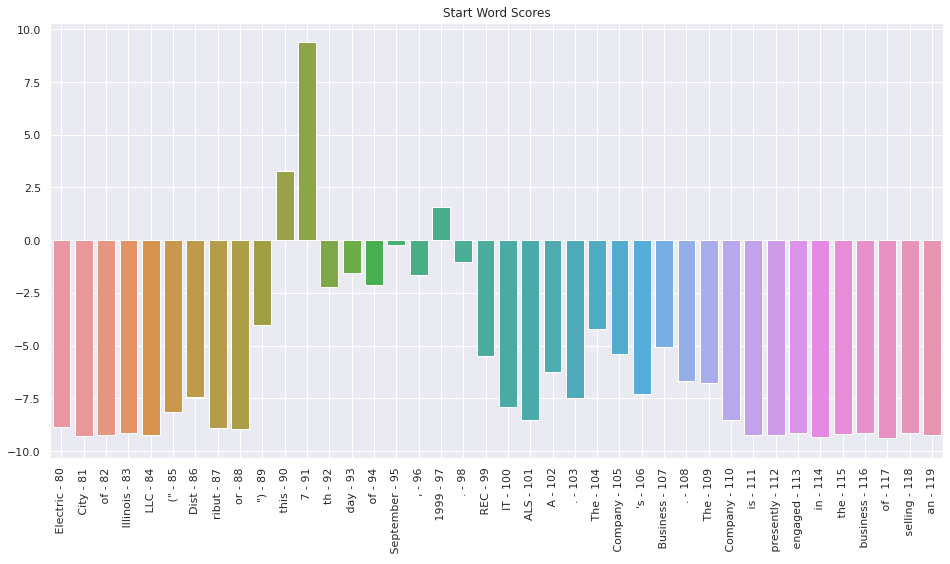

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(tokenizer.convert_tokens_to_string(token), i))

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels[80:120], y=s_scores[80:120], ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

In [10]:
start_index = torch.argmax(start_scores)
end_index = torch.argmax(end_scores)
answer = tokenizer.convert_tokens_to_string(tokens[start_index:end_index+1])
answer.strip()

'7th day of September, 1999.'

## Predictions

In [16]:
!ls

cuad-data  cuad-models	cuad-training  sample_data  scripts


In [17]:
from predict import run_prediction
import json

with open('./cuad-data/CUADv1.json') as json_file:
    data = json.load(json_file)



In [18]:
questions = []
for i, q in enumerate(data['data'][0]['paragraphs'][0]['qas']):
    question = data['data'][0]['paragraphs'][0]['qas'][i]['question']
    questions.append(question)
contract = data['data'][0]['paragraphs'][0]['context']

In [20]:
!mkdir temp
with open('temp/contract.txt', 'w') as f:
    f.write(' '.join(contract.split()))

predictions = run_prediction(questions, contract, 'cuad-models/roberta-base/')

add example index and unique id: 100%|██████████| 41/41 [00:00<00:00, 13551.34it/s]


In [21]:
with open('temp/predictions.txt', 'w') as f:
    for i, p in enumerate(predictions):
        f.write(f"Question {i+1}: {questions[int(p)]}\nAnswer: {predictions[p]}\n\n")